In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp


# =========================
# DESIGN system (y = [U,P,M])
# =========================
def rhs_design(z, X, c, lam, alpha):
    U, P, M = X
    D = M * (1.0 - M)
    dU = P
    dP = -c * P - U * (1.0 - U) * D
    dM = (D / c) * (lam * U * M - alpha * (1.0 - M))
    return [dU, dP, dM]

def make_stop_event_generic(blowU=5.0, blowP=5.0):
    """Guard: stop if M leaves [−1e-6, 1+1e-6] or |U|,|P| blow up."""
    def event(t, X, *args):
        U, P, M = X
        badM   = (M < -1e-6) or (M > 1.0 + 1e-6)
        blowUP = (not np.isfinite(U)) or (not np.isfinite(P)) or (abs(U) > blowU) or (abs(P) > blowP)
        return 0.0 if (badM or blowUP) else 1.0
    event.terminal  = True
    event.direction = 0
    return event

def make_event_hit_M(target=1.0, tol=1e-8, direction=+1):
    """
    Terminal event: stop when M reaches 'target' within 'tol'.
    direction=+1 -> trigger on increasing M; -1 -> on decreasing M.
    """
    target = float(target)
    def event(t, X, *args):
        M = X[2]
        # Zero when M crosses target - tol (for +1) or target + tol (for -1)
        return (M - (target - tol)) if direction > 0 else ((target + tol) - M)
    event.terminal  = True
    event.direction = 1 if direction > 0 else -1 if direction < 0 else 0
    return event

def _labels_from_speeds(speeds, c_ref, mode="relative"):
    labs = []
    for c in speeds:
        if mode == "relative" and c_ref is not None:
            eps = 1e-12
            if c < c_ref - eps:  labs.append(r"$c<c_{\rm ref}$")
            elif abs(c - c_ref) <= eps: labs.append(r"$c=c_{\rm ref}$")
            else: labs.append(r"$c>c_{\rm ref}$")
        else:
            labs.append(rf"$c={c:.6g}$")
    return labs

def integrate_and_plot_triptych_design(
    *,
    lam=1.0, alpha=0.0, m0=0.2,
    U0=0.99, P0=-0.01, M0=None,
    speeds=None,                 # explicit speeds (takes precedence)
    rel_speeds=(0.2, 1.0, 2.0),  # used if speeds is None; c = rel * c_ref
    label_mode="relative",       # "relative" vs c_ref or "numeric"
    z_end=100.0, dz=0.01,
    rtol=1e-10, atol=1e-12, max_step=5e-3,
    title_prefix="DESIGN",
    stop_at_M=None,              # NEW: None, or a float in [0,1] (e.g., 1.0 or 0.0)
    stop_tol=1e-8                # tolerance for hitting M target
):
    if M0 is None:
        M0 = m0

    # reference speed (used only for labels/relative construction)
    c_ref = 2.0 * np.sqrt(m0 * (1.0 - m0))  # c_min
    if speeds is not None:
        c_list = list(speeds)
    else:
        c_list = [c_ref * float(r) for r in rel_speeds]

    labels = _labels_from_speeds(c_list, c_ref, mode=label_mode)
    colors = ["tab:blue","purple","tab:orange","tab:green","tab:red"]

    # time grid
    t_eval = np.arange(0.0, z_end + dz, dz)

    # events
    guard_evt = make_stop_event_generic()
    events = [guard_evt]
    if stop_at_M is not None:
        target = float(stop_at_M)
        direction = +1 if target >= 0.5 else -1
        events.append(make_event_hit_M(target=target, tol=stop_tol, direction=direction))

    # integrate per speed
    sols = []
    for c in c_list:
        sol = solve_ivp(
            rhs_design, (0.0, z_end), [U0, P0, M0],
            args=(c, lam, alpha),
            method="BDF", rtol=rtol, atol=atol, max_step=max_step,
            t_eval=t_eval, events=events
        )
        sols.append((c, sol))

    # ---- 1×3 triptych projections ----
    idx = {'U':0,'P':1,'M':2}
    projs = [(('U','P'), "U vs P"), (('P','M'), "P vs M"), (('U','M'), "U vs M")]
    fig, axes = plt.subplots(1, 3, figsize=(15, 4.6), sharex=False, sharey=False)
    for ax, (pr, ttl) in zip(axes, projs):
        i, j = idx[pr[0]], idx[pr[1]]
        for (c, sol), col, lab in zip(sols, colors, labels):
            ax.plot(sol.y[i], sol.y[j], lw=2.0, color=col, label=lab)
        ax.grid(True, ls=":", alpha=0.6)
        ax.set_xlabel(pr[0]); ax.set_ylabel(pr[1]); ax.set_title(ttl)
    handles, labs = axes[0].get_legend_handles_labels()
    fig.legend(handles, labs, loc="upper center", ncol=min(5, len(labs)), frameon=False)
    fig.suptitle(f"{title_prefix}: triptych projections", y=1.02)
    plt.tight_layout(); plt.show()

    # ---- 3D trajectories ----
    from mpl_toolkits.mplot3d import Axes3D  # noqa
    fig = plt.figure(figsize=(6.8,5.6)); ax = fig.add_subplot(111, projection='3d')
    for (c, sol), col, lab in zip(sols, colors, labels):
        ax.plot(sol.y[0], sol.y[1], sol.y[2], color=col, lw=2.0, label=lab)
    ax.set_xlabel('U'); ax.set_ylabel('P'); ax.set_zlabel('M')
    ax.set_title(f"{title_prefix}: 3D trajectories")
    ax.legend(loc='best'); plt.tight_layout(); plt.show()

    # ---- Profiles vs z ----
    fig, axs = plt.subplots(3, 1, sharex=True, figsize=(7.5, 7.5))
    names = ['U','P','M']
    for k in range(3):
        for (c, sol), col in zip(sols, colors):
            axs[k].plot(sol.t, sol.y[k], color=col, lw=1.6)
        axs[k].set_ylabel(names[k]); axs[k].grid(True, ls=':')
    axs[-1].set_xlabel('z')
    fig.suptitle(rf"{title_prefix}  $m_0={m0:.3g}$, $c_{{\rm ref}}={c_ref:.6g}$, $\lambda={lam:g}$, $\alpha={alpha:g}$", y=0.97)
    plt.tight_layout(); plt.show()

    return {'c_ref': c_ref, 'c_list': c_list, 'solutions': [s for _,s in sols]}


# --- reuse your helpers (paste from your current file if not already present) ---
def rhs_design(z, X, c, lam, alpha):
    U, P, M = X
    D = M * (1.0 - M)
    dU = P
    dP = -c * P - U * (1.0 - U) * D
    dM = (D / c) * (lam * U * M - alpha * (1.0 - M))
    return [dU, dP, dM]

def make_stop_event_generic(blowU=5.0, blowP=5.0):
    def event(t, X, *args):
        U, P, M = X
        badM   = (M < -1e-6) or (M > 1.0 + 1e-6)
        blowUP = (not np.isfinite(U)) or (not np.isfinite(P)) or (abs(U) > blowU) or (abs(P) > blowP)
        return 0.0 if (badM or blowUP) else 1.0
    event.terminal  = True
    event.direction = 0
    return event

def make_event_hit_M(target=1.0, tol=1e-8, direction=+1):
    target = float(target)
    def event(t, X, *args):
        M = X[2]
        return (M - (target - tol)) if direction > 0 else ((target + tol) - M)
    event.terminal  = True
    event.direction = 1 if direction > 0 else -1 if direction < 0 else 0
    return event

def _labels_from_speeds(speeds, c_ref, mode="relative"):
    labs = []
    for c in speeds:
        if mode == "relative" and c_ref is not None:
            eps = 1e-12
            if c < c_ref - eps:  labs.append(r"$c<c_{\rm ref}$")
            elif abs(c - c_ref) <= eps: labs.append(r"$c=c_{\rm ref}$")
            else: labs.append(r"$c>c_{\rm ref}$")
        else:
            labs.append(rf"$c={c:.6g}$")
    return labs

# =========================
# LIVE triptych updater
# =========================
def integrate_and_plot_triptych_design_live(
    *,
    lam=1.0, alpha=0.0, m0=0.2,
    U0=0.99, P0=-0.01, M0=None,
    speeds=None, rel_speeds=(0.2,1.0,2.0), label_mode="relative",
    z_end=100.0, dz=0.01,            # dz = sampling spacing for plotting
    chunk_z=5.0,                     # integrate in chunks of this z-length
    refresh_every=1,                 # refresh plots every N chunks
    rtol=1e-12, atol=1e-14, max_step=5e-3,
    stop_at_M=None, stop_tol=1e-8,
    title_prefix="DESIGN (live)",
    show=True
):
    """
    Incremental solver with live 1x3 projections refresh.
    """
    if M0 is None:
        M0 = m0

    # Build speed list
    c_ref = 2.0*np.sqrt(m0*(1.0-m0))  # used only for relative labels
    if speeds is not None:
        c_list = list(speeds)
    else:
        c_list = [c_ref*float(r) for r in rel_speeds]
    labels = _labels_from_speeds(c_list, c_ref, mode=label_mode)
    colors = ["tab:blue","purple","tab:orange","tab:green","tab:red"]

    # Events
    events = [make_stop_event_generic()]
    if stop_at_M is not None:
        direction = +1 if float(stop_at_M) >= 0.5 else -1
        events.append(make_event_hit_M(target=float(stop_at_M), tol=stop_tol, direction=direction))

    # Allocate accumulators per speed
    data = []
    for _ in c_list:
        data.append({
            't': [0.0], 'U': [U0], 'P': [P0], 'M': [M0],
            'alive': True, 'status': 'running'
        })

    # --- Set up live figure (1x3 triptych) ---
    if show:
        plt.ion()
        fig, axes = plt.subplots(1,3, figsize=(15,4.6))
        projs = [(('U','P'),"U vs P"), (('P','M'),"P vs M"), (('U','M'),"U vs M")]
        idx = {'U':'U','P':'P','M':'M'}
        # Create line handles
        lines = [[None for _ in c_list] for _ in range(3)]
        for a,(pr,ttl) in enumerate(projs):
            ax = axes[a]
            ax.grid(True, ls=':', alpha=0.6)
            ax.set_xlabel(pr[0]); ax.set_ylabel(pr[1]); ax.set_title(ttl)
            for k,(c,lab,col) in enumerate(zip(c_list, labels, colors)):
                ln, = ax.plot([], [], lw=2.0, color=col, label=lab)
                lines[a][k] = ln
        # one legend above
        handles = [lines[0][k] for k in range(len(c_list))]
        axes[0].legend(handles, labels, loc='best', frameon=False)
        fig.suptitle(f"{title_prefix}: live triptych", y=1.02)
        fig.tight_layout()
        fig.canvas.draw(); fig.canvas.flush_events()

    # --- Incremental integration loop ---
    n_chunks = int(np.ceil(z_end / chunk_z))
    for chunk in range(n_chunks):
        t0, t1 = chunk*chunk_z, min((chunk+1)*chunk_z, z_end)
        t_eval = np.arange(t0, t1 + 1e-12, dz) if dz>0 else None

        for k, c in enumerate(c_list):
            if not data[k]['alive']:
                continue
            y0 = [data[k]['U'][-1], data[k]['P'][-1], data[k]['M'][-1]]
            sol = solve_ivp(
                rhs_design, (t0, t1), y0,
                args=(c, lam, alpha),
                method="BDF", rtol=rtol, atol=atol, max_step=max_step,
                t_eval=t_eval, events=events
            )
            # Append (skip first point to avoid duplicates)
            if sol.t.size > 1:
                data[k]['t'].extend(sol.t[1:].tolist())
                data[k]['U'].extend(sol.y[0,1:].tolist())
                data[k]['P'].extend(sol.y[1,1:].tolist())
                data[k]['M'].extend(sol.y[2,1:].tolist())

            # Check termination
            if sol.status != 0:  # event or failure
                data[k]['alive'] = False
                if sol.status == 1:
                    data[k]['status'] = 'event'
                else:
                    data[k]['status'] = 'failed'

        # Refresh plots every refresh_every chunks
        if show and ((chunk+1) % max(1, refresh_every) == 0 or (chunk+1) == n_chunks):
            for a,(pr,_) in enumerate(projs):
                i, j = pr
                for k in range(len(c_list)):
                    x = data[k][i]; y = data[k][j]
                    lines[a][k].set_data(x, y)
                axes[a].relim(); axes[a].autoscale_view()
            fig.canvas.draw(); fig.canvas.flush_events()
            plt.pause(0.01)  # brief yield to UI

        # Stop early if everyone is done
        if not any(d['alive'] for d in data):
            break

    if show:
        plt.ioff()

    # Build return object similar to your batch runner
    results = []
    for k,c in enumerate(c_list):
        results.append({
            'c': c,
            'status': data[k]['status'],
            't': np.asarray(data[k]['t']),
            'y': np.vstack([np.asarray(data[k]['U']),
                            np.asarray(data[k]['P']),
                            np.asarray(data[k]['M'])])
        })
    return {
        'c_ref': c_ref,
        'c_list': c_list,
        'runs': results
    }

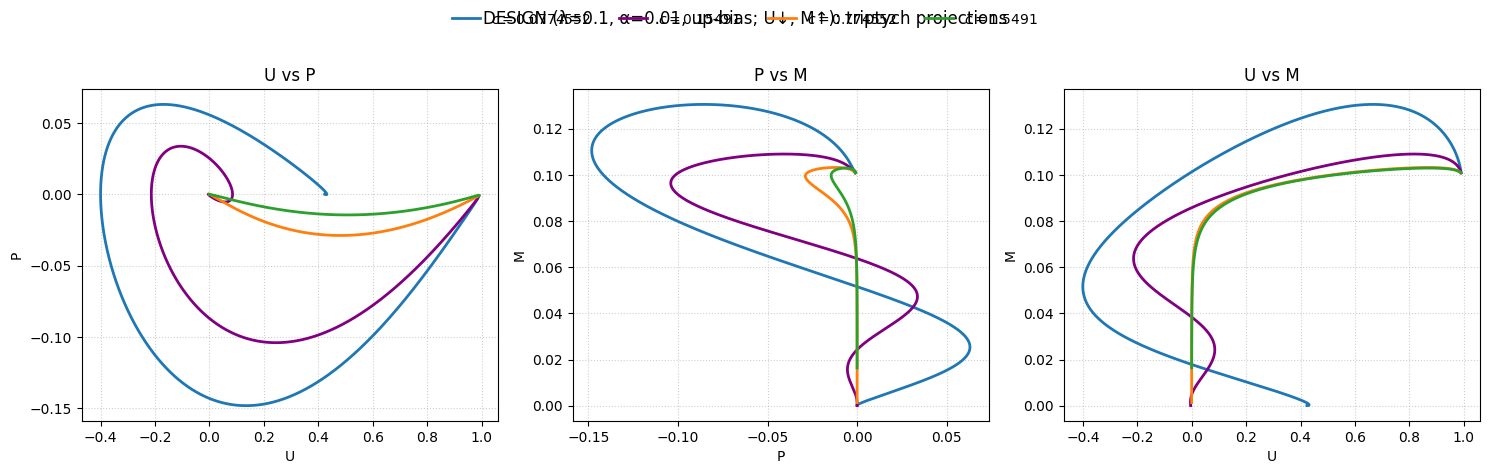

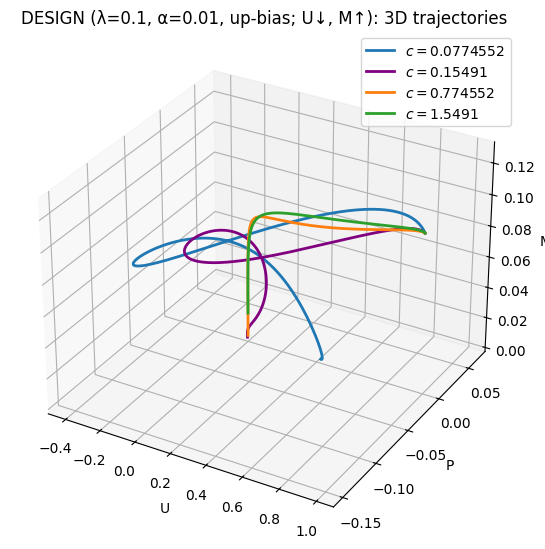

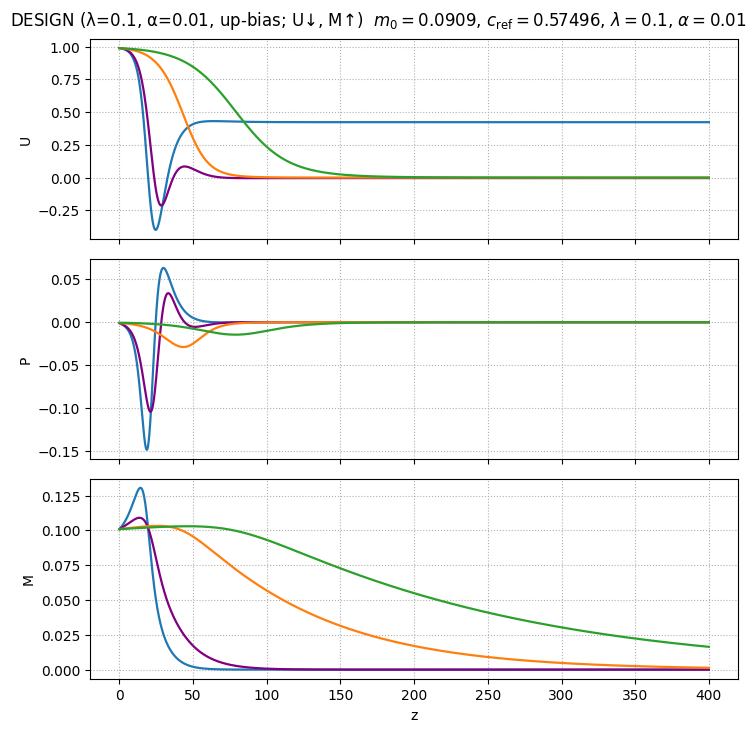

{'c_ref': np.float64(0.5749595745760689),
 'c_list': [0.07745515344542842,
  0.15491030689085683,
  0.774551534454284,
  1.549103068908568],
 'solutions': [  message: The solver successfully reached the end of the integration interval.
    success: True
     status: 0
          t: [ 0.000e+00  1.000e-02 ...  4.000e+02  4.000e+02]
          y: [[ 9.900e-01  9.900e-01 ...  4.236e-01  4.236e-01]
              [-1.000e-03 -1.008e-03 ... -7.931e-15 -7.925e-15]
              [ 1.009e-01  1.009e-01 ...  3.802e-23  3.796e-23]]
        sol: None
   t_events: [array([], dtype=float64), array([], dtype=float64)]
   y_events: [array([], dtype=float64), array([], dtype=float64)]
       nfev: 80040
       njev: 1
        nlu: 6566,
    message: The solver successfully reached the end of the integration interval.
    success: True
     status: 0
          t: [ 0.000e+00  1.000e-02 ...  4.000e+02  4.000e+02]
          y: [[ 9.900e-01  9.900e-01 ... -3.753e-03 -3.753e-03]
              [-1.000e-03 -1.0

In [9]:
lam   = 0.1
alpha = 0.01
c_meas = 0.774551534454284
mbar = alpha/(alpha+lam)     # ~0.090909
eps_up = 0.01                # bias toward M→1

integrate_and_plot_triptych_design(
    lam=lam, alpha=alpha, m0=mbar,
    U0=0.99,            # <-- nudge U below 1  (or keep U0=1 and set P0=-0.005)
    P0=-0.001,          # <-- small negative momentum makes U start decreasing
    M0=min(1.0-1e-9, mbar + eps_up),
    speeds=[ .2*c_meas, c_meas, 2*c_meas], label_mode="numeric",
    z_end=400.0, dz=0.01,
    rtol=1e-12, atol=1e-14, max_step=0.01,
    title_prefix="DESIGN (λ=0.1, α=0.01, up-bias; U↓, M↑)",
    stop_at_M=1.0, stop_tol=1e-8     # optional: stop when M hits ~1
)

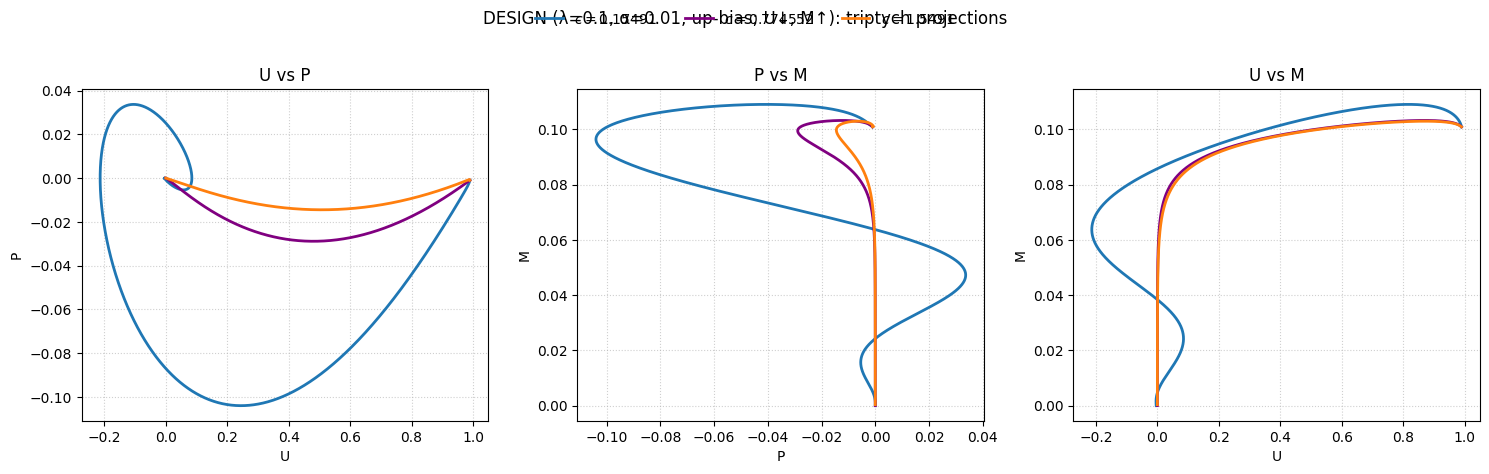

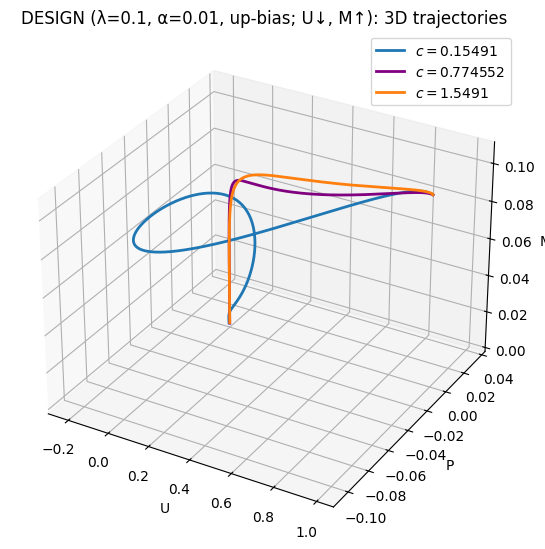

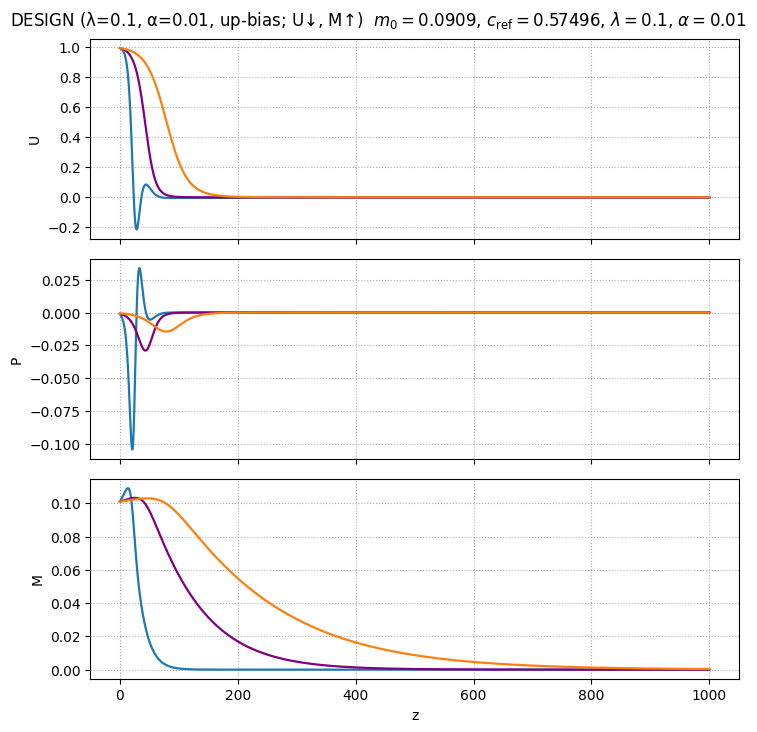

{'c_ref': np.float64(0.5749595745760689),
 'c_list': [0.15491030689085683, 0.774551534454284, 1.549103068908568],
 'solutions': [  message: The solver successfully reached the end of the integration interval.
    success: True
     status: 0
          t: [ 0.000e+00  1.000e-02 ...  1.000e+03  1.000e+03]
          y: [[ 9.900e-01  9.900e-01 ... -3.753e-03 -3.753e-03]
              [-1.000e-03 -1.007e-03 ...  1.732e-30  1.731e-30]
              [ 1.009e-01  1.009e-01 ...  4.155e-29  4.152e-29]]
        sol: None
   t_events: [array([], dtype=float64), array([], dtype=float64)]
   y_events: [array([], dtype=float64), array([], dtype=float64)]
       nfev: 200040
       njev: 1
        nlu: 32902,
    message: The solver successfully reached the end of the integration interval.
    success: True
     status: 0
          t: [ 0.000e+00  1.000e-02 ...  1.000e+03  1.000e+03]
          y: [[ 9.900e-01  9.900e-01 ...  4.724e-06  4.724e-06]
              [-1.000e-03 -1.001e-03 ... -3.564e-12 -3.

In [11]:
lam   = 0.1
alpha = 0.01
c_meas = 0.774551534454284
mbar = alpha/(alpha+lam)     # ~0.090909
eps_up = 0.01                # bias toward M→1

integrate_and_plot_triptych_design(
    lam=lam, alpha=alpha, m0=mbar,
    U0=0.99,            # <-- nudge U below 1  (or keep U0=1 and set P0=-0.005)
    P0=-0.001,          # <-- small negative momentum makes U start decreasing
    M0=min(1.0-1e-9, mbar + eps_up),
    speeds=[.2*c_meas, c_meas, 2*c_meas], label_mode="numeric",
    z_end=1000.0, dz=0.01,
    rtol=1e-12, atol=1e-14, max_step=0.01,
    title_prefix="DESIGN (λ=0.1, α=0.01, up-bias; U↓, M↑)",
    stop_at_M=1.0, stop_tol=1e-8     # optional: stop when M hits ~1
)

/var/folders/db/nfyhgnf50fxd8qjfrpdb671c0000gn/T/ipykernel_68514/3362575084.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.86, 0.96])  # leave space on right for legend


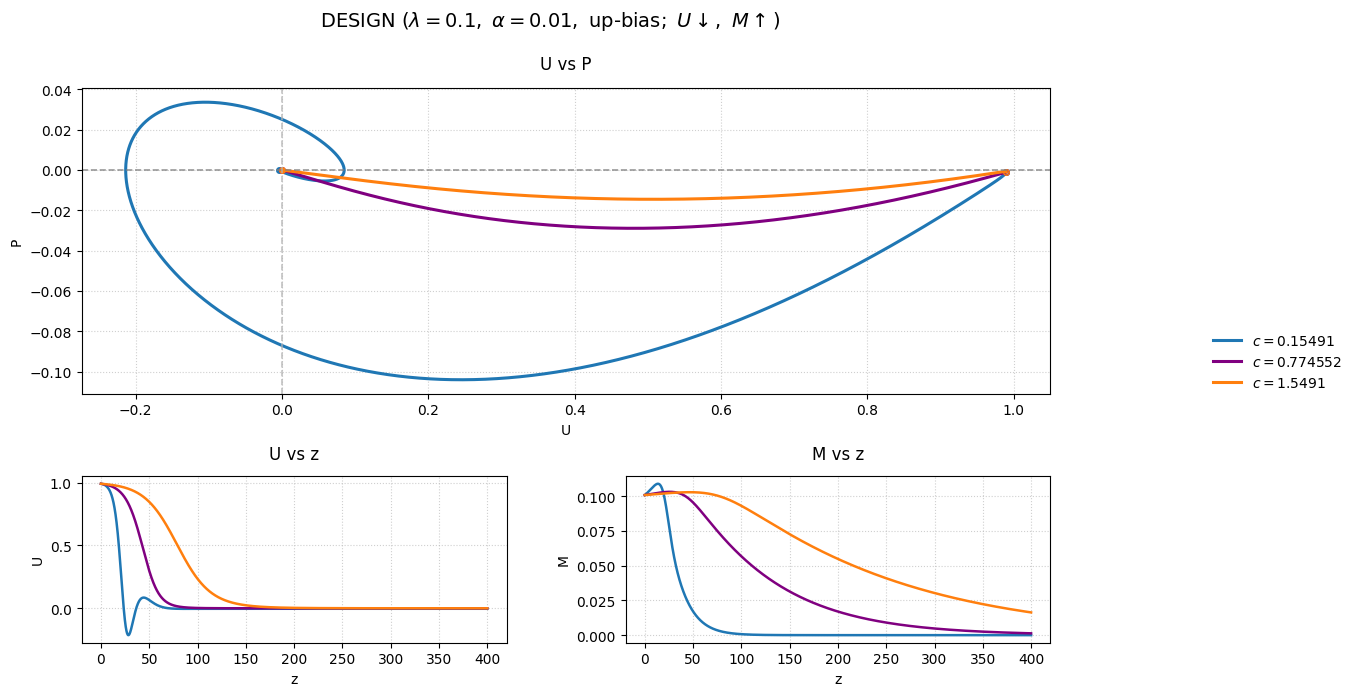

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from scipy.integrate import solve_ivp

# ====== system & helpers (y = [U,P,M]) ======
def rhs_design(z, X, c, lam, alpha):
    U, P, M = X
    D = M * (1.0 - M)
    return [P,
            -c * P - U * (1.0 - U) * D,
            (D / c) * (lam * U * M - alpha * (1.0 - M))]

def make_stop_event_generic(blowU=5.0, blowP=5.0):
    def event(t, X, *args):
        U, P, M = X
        badM   = (M < -1e-6) or (M > 1.0 + 1e-6)
        blowUP = (not np.isfinite(U)) or (not np.isfinite(P)) or (abs(U) > blowU) or (abs(P) > blowP)
        return 0.0 if (badM or blowUP) else 1.0
    event.terminal  = True
    event.direction = 0
    return event

def make_event_hit_M(target=1.0, tol=1e-8, direction=+1):
    target = float(target)
    def event(t, X, *args):
        M = X[2]
        return (M - (target - tol)) if direction > 0 else ((target + tol) - M)
    event.terminal  = True
    event.direction = 1 if direction > 0 else -1 if direction < 0 else 0
    return event

def _labels_from_speeds(speeds, c_ref, mode="relative"):
    labs = []
    for c in speeds:
        if mode == "relative" and c_ref is not None:
            eps = 1e-12
            labs.append(r"$c<c_{\rm ref}$" if c < c_ref - eps
                        else (r"$c=c_{\rm ref}$" if abs(c-c_ref) <= eps else r"$c>c_{\rm ref}$"))
        else:
            labs.append(rf"$c={c:.6g}$")
    return labs


# ====== HERO layout: big U–P on top, U(z) & M(z) below ======
def integrate_and_plot_hero_design(
    *,
    lam=1.0, alpha=0.0, m0=0.2,
    U0=0.99, P0=-0.01, M0=None,
    speeds=None, rel_speeds=(0.2, 1.0, 2.0),
    label_mode="relative",
    z_end=100.0, dz=0.01,
    rtol=1e-12, atol=1e-14, max_step=5e-3,
    title_prefix="DESIGN (hero)",
    stop_at_M=None, stop_tol=1e-8
):
    if M0 is None:
        M0 = m0

    # build speed list
    c_ref = 2.0*np.sqrt(m0*(1.0-m0))  # used only for relative labels
    if speeds is not None:
        c_list = list(speeds)
    else:
        c_list = [c_ref*float(r) for r in rel_speeds]
    labels = _labels_from_speeds(c_list, c_ref, mode=label_mode)
    colors = ["tab:blue","purple","tab:orange","tab:green","tab:red"]

    # time grid & events
    t_eval = np.arange(0.0, z_end + dz, dz)
    events = [make_stop_event_generic()]
    if stop_at_M is not None:
        direction = +1 if float(stop_at_M) >= 0.5 else -1
        events.append(make_event_hit_M(target=float(stop_at_M), tol=stop_tol, direction=direction))

    # integrate per speed
    sols = []
    for c in c_list:
        sol = solve_ivp(
            rhs_design, (0.0, z_end), [U0, P0, M0],
            args=(c, lam, alpha),
            method="BDF", rtol=rtol, atol=atol, max_step=max_step,
            t_eval=t_eval, events=events
        )
        sols.append((c, sol))

    # ---------- figure: big top + 2 bottoms ----------
    fig = plt.figure(figsize=(12.5, 7.2))
    gs = GridSpec(2, 2, height_ratios=[2.2, 1.2], hspace=0.35, wspace=0.28)

    # Top: big U–P
    ax_up = fig.add_subplot(gs[0, :])
    for (c, sol), col, lab in zip(sols, colors, labels):
        U, P = sol.y[0], sol.y[1]
        ax_up.plot(U, P, lw=2.2, color=col, label=lab)
        # start/end markers
        ax_up.plot(U[0],  P[0],  marker='o', ms=4, mfc='none', mec=col)
        ax_up.plot(U[-1], P[-1], marker='o', ms=4, mfc=col,   mec=col)
    ax_up.axhline(0, ls='--', lw=1.2, color='0.5', alpha=0.8)  # P=0 guide
    ax_up.axvline(0, ls='--', lw=1.2, color='0.7', alpha=0.8)  # U=0 guide
    ax_up.grid(True, ls=':', alpha=0.6)
    ax_up.set_xlabel("U")
    ax_up.set_ylabel("P")
    ax_up.set_title("U vs P", pad=14)

    # Bottom-left: U(z)
    ax_Uz = fig.add_subplot(gs[1, 0], sharex=None)
    for (c, sol), col in zip(sols, colors):
        ax_Uz.plot(sol.t, sol.y[0], color=col, lw=1.8)
    ax_Uz.grid(True, ls=":", alpha=0.6)
    ax_Uz.set_xlabel("z")
    ax_Uz.set_ylabel("U")
    ax_Uz.set_title("U vs z", pad=12)

    # Bottom-right: M(z)
    ax_Mz = fig.add_subplot(gs[1, 1], sharex=ax_Uz)
    for (c, sol), col in zip(sols, colors):
        ax_Mz.plot(sol.t, sol.y[2], color=col, lw=1.8)
    ax_Mz.grid(True, ls=":", alpha=0.6)
    ax_Mz.set_xlabel("z")
    ax_Mz.set_ylabel("M")
    ax_Mz.set_title("M vs z", pad=12)

    # Shared legend on the right (for all subplots)
    handles, labs = ax_up.get_legend_handles_labels()
    fig.legend(handles, labs,
               loc="center left", bbox_to_anchor=(1.02, 0.5),
               frameon=False, title=None)

    # Suptitle nicely centered
    fig.suptitle(title_prefix, y=0.99, fontsize=14)
    plt.tight_layout(rect=[0, 0, 0.86, 0.96])  # leave space on right for legend
    plt.show()

    return {'c_ref': c_ref, 'c_list': c_list, 'solutions': [s for _, s in sols]}


# ====== Your requested call ======
if __name__ == "__main__":
    lam   = 0.1
    alpha = 0.01
    c_meas = 0.774551534454284
    mbar = alpha/(alpha+lam)     # ~0.090909
    eps_up = 0.01                # bias toward M→1

    integrate_and_plot_hero_design(
        lam=lam, alpha=alpha, m0=mbar,
        U0=0.99,          # or U0=1.0 with P0 negative
        P0=-0.001,
        M0=min(1.0-1e-9, mbar + eps_up),
        speeds=[0.2*c_meas, c_meas, 2.0*c_meas],  # three speeds
        label_mode="numeric",
        z_end=400.0, dz=0.01,
        rtol=1e-12, atol=1e-14, max_step=0.01,
        title_prefix=r"DESIGN $(\lambda=0.1,\ \alpha=0.01,\ \text{up-bias};\ U\downarrow,\ M\uparrow)$",
        stop_at_M=1.0, stop_tol=1e-8
    )

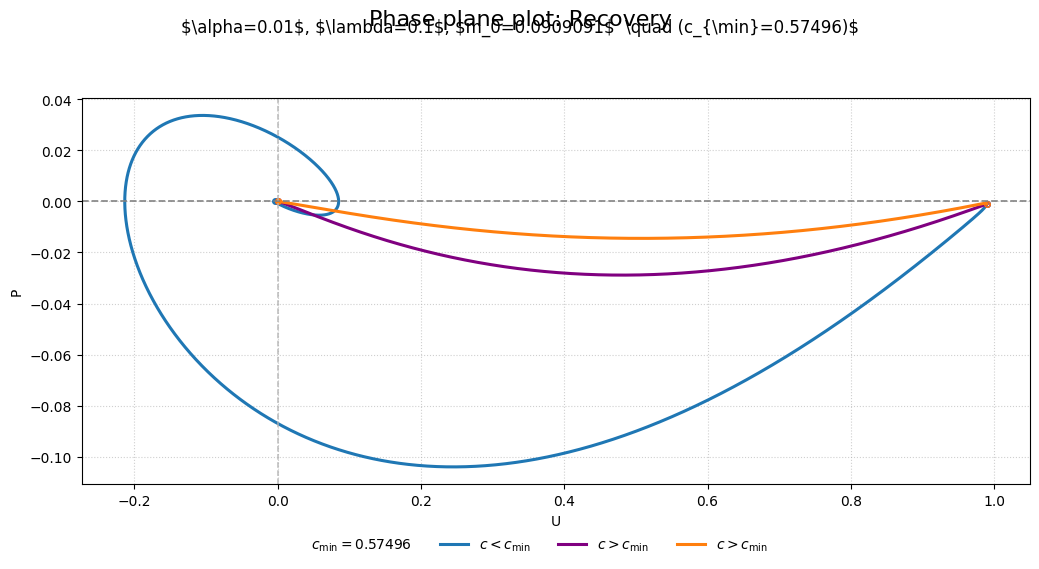

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# ---------- system ----------
def rhs_design(z, X, c, lam, alpha):
    U, P, M = X
    D = M*(1.0 - M)
    dU = P
    dP = -c*P - U*(1.0 - U)*D
    dM = (D/c)*(lam*U*M - alpha*(1.0 - M))
    return [dU, dP, dM]

def make_stop_event_generic(blowU=5.0, blowP=5.0):
    def event(t, X, *args):
        U, P, M = X
        badM   = (M < -1e-6) or (M > 1.0 + 1e-6)
        blowUP = (not np.isfinite(U)) or (not np.isfinite(P)) or (abs(U)>blowU) or (abs(P)>blowP)
        return 0.0 if (badM or blowUP) else 1.0
    event.terminal  = True
    event.direction = 0
    return event

# ---------- hero-only plot ----------
def plot_hero_phaseplane_recovery(
    *,
    lam, alpha, m0,
    U0=0.99, P0=-0.001, M0=None,
    speeds=None,                 # list of c values (e.g. [0.2*c, c, 2*c])
    z_end=400.0, dz=0.01,
    rtol=1e-12, atol=1e-14, max_step=0.01
):
    if M0 is None:
        M0 = m0

    # reference speed for the design system
    cmin = 2.0*np.sqrt(m0*(1.0 - m0))

    # integrate for each speed
    colors = ["tab:blue","purple","tab:orange","tab:green","tab:red"]
    t_eval = np.arange(0.0, z_end+dz, dz)
    guard_evt = make_stop_event_generic()

    sols = []
    for c in speeds:
        sol = solve_ivp(
            rhs_design, (0.0, z_end), [U0, P0, M0],
            args=(c, lam, alpha),
            method="BDF", rtol=rtol, atol=atol, max_step=max_step,
            t_eval=t_eval, events=guard_evt
        )
        sols.append((c, sol))

    # labels relative to cmin
    def rel_lab(c, cmin, eps=1e-12):
        if c < cmin - eps: return r"$c<c_{\min}$"
        if abs(c - cmin) <= eps: return r"$c=c_{\min}$"
        return r"$c>c_{\min}$"

    # ---- big figure ----
    fig, ax = plt.subplots(figsize=(10.5, 5.8))

    # plot trajectories + markers
    for (c, sol), col in zip(sols, colors):
        U, P = sol.y[0], sol.y[1]
        ax.plot(U, P, lw=2.2, color=col, label=rel_lab(c, cmin))
        ax.plot(U[0],  P[0],  marker='o', ms=4, mfc='none', mec=col)  # start
        ax.plot(U[-1], P[-1], marker='o', ms=4, mfc=col,   mec=col)   # end

    # guides
    ax.axhline(0, ls='--', lw=1.3, color='0.5', alpha=0.9)
    ax.axvline(0, ls='--', lw=1.1, color='0.7', alpha=0.9)

    ax.grid(True, ls=':', alpha=0.6)
    ax.set_xlabel("U")
    ax.set_ylabel("P")

    # main title + subtitle (centered)
    fig.suptitle("Phase plane plot: Recovery", y=0.98, fontsize=16)
    plt.figtext(
        0.5, 0.94,
        rf"$\alpha={alpha:g}$, $\lambda={lam:g}$, $m_0={m0:.6g}$  \quad (c_{{\min}}={cmin:.6g})$",
        ha="center", fontsize=12
    )

    # legend at bottom, horizontal; include an entry showing numeric c_min
    handles, labels = ax.get_legend_handles_labels()
    # prepend cmin numeric as a “pseudo” handle (empty)
    labels = [rf"$c_{{\min}}={cmin:.6g}$"] + labels
    handles = [plt.Line2D([], [], color='none')] + handles

    fig.legend(handles, labels, loc="lower center", ncol=min(4, len(labels)),
               frameon=False, bbox_to_anchor=(0.5, 0.02))

    plt.tight_layout(rect=[0, 0.06, 1, 0.92])
    plt.show()

    return {"cmin": cmin, "speeds": speeds, "solutions": [s for _, s in sols]}

# ---------- example call with your numbers ----------
if __name__ == "__main__":
    lam   = 0.1
    alpha = 0.01
    c_meas = 0.774551534454284
    mbar = alpha/(alpha + lam)       # ≈ 0.090909
    eps_up = 0.01

    plot_hero_phaseplane_recovery(
        lam=lam, alpha=alpha, m0=mbar,
        U0=0.99, P0=-0.001, M0=min(1.0-1e-9, mbar + eps_up),
        speeds=[0.2*c_meas, c_meas, 2.0*c_meas],
        z_end=400.0, dz=0.01,
        rtol=1e-12, atol=1e-14, max_step=0.01
    )

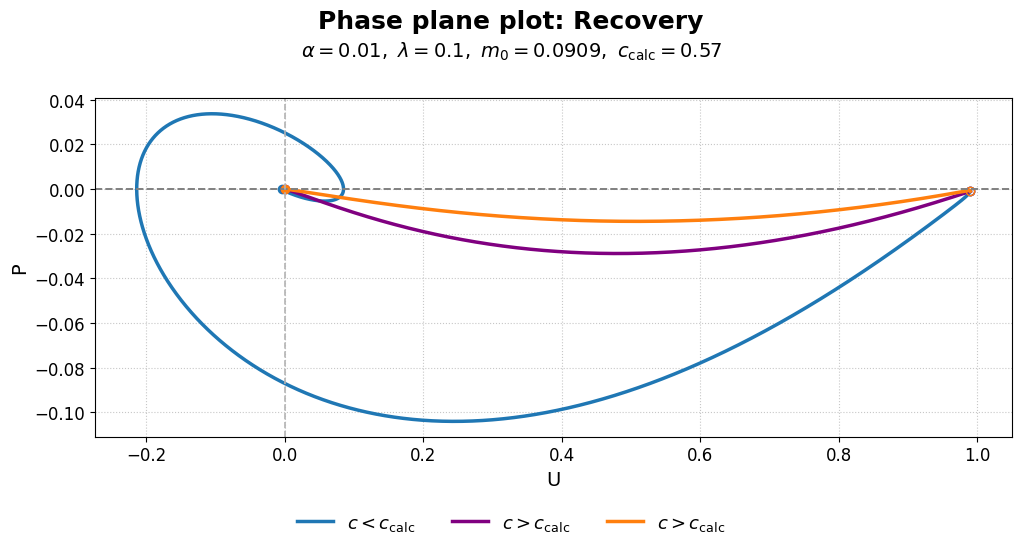

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

def rhs_design(z, X, c, lam, alpha):
    U, P, M = X
    D = M*(1.0 - M)
    dU = P
    dP = -c*P - U*(1.0 - U)*D
    dM = (D/c)*(lam*U*M - alpha*(1.0 - M))
    return [dU, dP, dM]

def make_stop_event_generic(blowU=5.0, blowP=5.0):
    def event(t, X, *args):
        U, P, M = X
        badM   = (M < -1e-6) or (M > 1.0 + 1e-6)
        blowUP = (not np.isfinite(U)) or (not np.isfinite(P)) or (abs(U)>blowU) or (abs(P)>blowP)
        return 0.0 if (badM or blowUP) else 1.0
    event.terminal  = True
    event.direction = 0
    return event

def plot_phaseplane_recovery_appendix(
    *, lam, alpha, m0,
    U0=0.99, P0=-0.001, M0=None,
    speeds=None, z_end=400.0, dz=0.01,
    rtol=1e-12, atol=1e-14, max_step=0.01
):
    if M0 is None:
        M0 = m0
    cmin = 2.0*np.sqrt(m0*(1.0 - m0))  # reference speed

    t_eval = np.arange(0.0, z_end+dz, dz)
    guard_evt = make_stop_event_generic()

    sols = []
    for c in speeds:
        sol = solve_ivp(
            rhs_design, (0.0, z_end), [U0, P0, M0],
            args=(c, lam, alpha),
            method="BDF", rtol=rtol, atol=atol, max_step=max_step,
            t_eval=t_eval, events=guard_evt
        )
        sols.append((c, sol))

    def rel_lab(c, cmin, eps=1e-12):
        if c < cmin - eps: return r"$c<c_{\rm calc}$"
        if abs(c - cmin) <= eps: return r"$c=c_{\rm calc}$"
        return r"$c>c_{\rm calc}$"

    fig, ax = plt.subplots(figsize=(10.5, 6))

    colors = ["tab:blue","purple","tab:orange"]
    for (c, sol), col in zip(sols, colors):
        U, P = sol.y[0], sol.y[1]
        ax.plot(U, P, lw=2.5, color=col, label=rel_lab(c, cmin))
        ax.plot(U[0],  P[0],  marker='o', ms=6, mfc='none', mec=col)
        ax.plot(U[-1], P[-1], marker='o', ms=6, mfc=col, mec=col)

    ax.axhline(0, ls='--', lw=1.4, color='0.5')
    ax.axvline(0, ls='--', lw=1.2, color='0.7')
    ax.grid(True, ls=':', alpha=0.7)
    ax.set_xlabel("U", fontsize=14)
    ax.set_ylabel("P", fontsize=14)
    ax.tick_params(axis='both', labelsize=12)

    # Title + subtitle (subtitle shifted lower)
    fig.suptitle("Phase plane plot: Recovery", y=0.96, fontsize=18, weight='bold')
    plt.figtext(
        0.5, 0.91,
        rf"$\alpha={alpha:g}, \ \lambda={lam:g}, \ m_0={m0:.3g}, \ c_{{\rm calc}}$",
        ha="center", fontsize=14
    )

    # Legend at bottom
    handles, labels = ax.get_legend_handles_labels()
    labels = [r"$c_{\rm calc}$"] + labels
    handles = [plt.Line2D([], [], color='none')] + handles
    fig.legend(handles, labels, loc="lower center", ncol=4,
               frameon=False, fontsize=13, bbox_to_anchor=(0.5, 0.02))

    plt.tight_layout(rect=[0, 0.08, 1, 0.92])
    plt.show()

def plot_phaseplane_recovery_appendix(
    *, lam, alpha, m0,
    U0=0.99, P0=-0.001, M0=None,
    speeds=None, z_end=400.0, dz=0.01,
    rtol=1e-12, atol=1e-14, max_step=0.01
):
    if M0 is None:
        M0 = m0
    cmin = 2.0*np.sqrt(m0*(1.0 - m0))  # reference speed

    t_eval = np.arange(0.0, z_end+dz, dz)
    guard_evt = make_stop_event_generic()

    sols = []
    for c in speeds:
        sol = solve_ivp(
            rhs_design, (0.0, z_end), [U0, P0, M0],
            args=(c, lam, alpha),
            method="BDF", rtol=rtol, atol=atol, max_step=max_step,
            t_eval=t_eval, events=guard_evt
        )
        sols.append((c, sol))

    def rel_lab(c, cmin, eps=1e-12):
        if c < cmin - eps: return r"$c<c_{\rm calc}$"
        if abs(c - cmin) <= eps: return r"$c=c_{\rm calc}$"
        return r"$c>c_{\rm calc}$"

    fig, ax = plt.subplots(figsize=(10.5, 6))

    colors = ["tab:blue","purple","tab:orange"]
    labels = []
    for (c, sol), col in zip(sols, colors):
        U, P = sol.y[0], sol.y[1]
        lab = rel_lab(c, cmin)
        ax.plot(U, P, lw=2.5, color=col, label=lab)
        ax.plot(U[0],  P[0],  marker='o', ms=6, mfc='none', mec=col)
        ax.plot(U[-1], P[-1], marker='o', ms=6, mfc=col, mec=col)
        labels.append(lab)

    ax.axhline(0, ls='--', lw=1.4, color='0.5')
    ax.axvline(0, ls='--', lw=1.2, color='0.7')
    ax.grid(True, ls=':', alpha=0.7)
    ax.set_xlabel("U", fontsize=14)
    ax.set_ylabel("P", fontsize=14)
    ax.tick_params(axis='both', labelsize=12)

    # Main title + subtitle
    fig.suptitle("Phase plane plot: Recovery", y=0.92, fontsize=18, weight='bold')
    plt.figtext(
        0.5, 0.84,
        rf"$\alpha={alpha:g}, \ \lambda={lam:g}, \ m_0={m0:.3g}, \ c_{{\rm calc}}={cmin:.2f}$",
        ha="center", fontsize=14
    )

    # Legend at bottom with only 3 entries
    handles, labs = ax.get_legend_handles_labels()
    fig.legend(handles, labs, loc="lower center", ncol=3,
               frameon=False, fontsize=13, bbox_to_anchor=(0.5, 0.02))

    plt.tight_layout(rect=[0, 0.08, 1, 0.9])
    plt.show()

# ---- Example call ----
lam   = 0.1
alpha = 0.01
c_meas = 0.774551534454284
mbar = alpha/(alpha + lam)
eps_up = 0.01

plot_phaseplane_recovery_appendix(
    lam=lam, alpha=alpha, m0=mbar,
    U0=0.99, P0=-0.001, M0=min(1.0-1e-9, mbar + eps_up),
    speeds=[0.2*c_meas, c_meas, 2.0*c_meas],
    z_end=400.0, dz=0.01
)

In [23]:
def plot_phaseplane_recovery_appendix(
    *, lam, alpha, m0,
    U0=0.99, P0=-0.001, M0=None,
    speeds=None, z_end=400.0, dz=0.01,
    rtol=1e-12, atol=1e-14, max_step=0.01
):
    if M0 is None:
        M0 = m0
    cmin = 2.0*np.sqrt(m0*(1.0 - m0))  # reference speed

    t_eval = np.arange(0.0, z_end+dz, dz)
    guard_evt = make_stop_event_generic()

    sols = []
    for c in speeds:
        sol = solve_ivp(
            rhs_design, (0.0, z_end), [U0, P0, M0],
            args=(c, lam, alpha),
            method="BDF", rtol=rtol, atol=atol, max_step=max_step,
            t_eval=t_eval, events=guard_evt
        )
        sols.append((c, sol))

    def rel_lab(c, cmin, eps=1e-12):
        if c < cmin - eps: return r"$c<c_{\rm calc}$"
        if abs(c - cmin) <= eps: return r"$c=c_{\rm calc}$"
        return r"$c>c_{\rm calc}$"

    fig, ax = plt.subplots(figsize=(10.5, 6))

    colors = ["tab:blue","purple","tab:orange"]
    for (c, sol), col in zip(sols, colors):
        U, P = sol.y[0], sol.y[1]
        ax.plot(U, P, lw=2.5, color=col, label=rel_lab(c, cmin))
        ax.plot(U[0],  P[0],  marker='o', ms=6, mfc='none', mec=col)
        ax.plot(U[-1], P[-1], marker='o', ms=6, mfc=col, mec=col)

    # Axes styling
    ax.axhline(0, ls='--', lw=1.4, color='0.5')
    ax.axvline(0, ls='--', lw=1.2, color='0.7')
    ax.grid(True, ls=':', alpha=0.7)
    ax.set_xlabel("U", fontsize=14)
    ax.set_ylabel("P", fontsize=14)
    ax.tick_params(axis='both', labelsize=12)
    ax.yaxis.set_major_locator(MaxNLocator(nbins=5))  # ~5 ticks on y-axis

    # Main title + subtitle
    fig.suptitle("Phase plane plot: Recovery", y=0.94, fontsize=18, weight='bold')
    plt.figtext(
        0.5, 0.88,
        rf"$\alpha={alpha:g}, \ \lambda={lam:g}, \ m_0={m0:.3g}, \ c_{{\rm calc}}={cmin:.2f}$",
        ha="center", fontsize=14
    )

    # Legend on the RIGHT
    fig.legend(*ax.get_legend_handles_labels(),
               loc="center left", bbox_to_anchor=(1.02, 0.5),
               frameon=False, fontsize=15)

    # Leave space on right for legend
    plt.tight_layout(rect=[0, 0, 0.82, 0.92])
    plt.show()

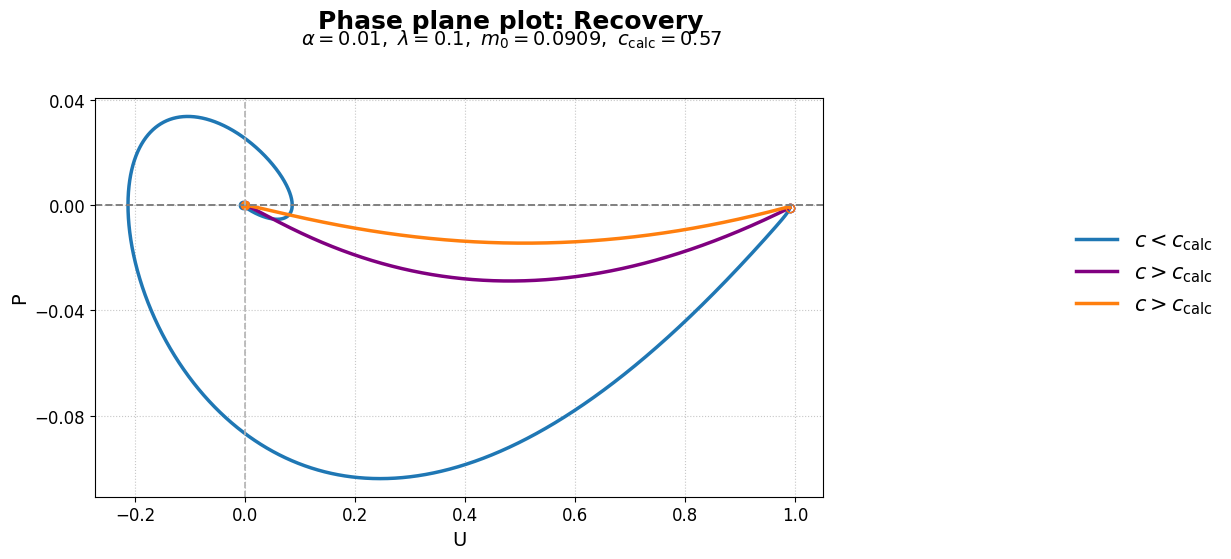

In [24]:
# ---- Example call ----
lam   = 0.1
alpha = 0.01
c_meas = 0.774551534454284  # measured invasion speed from PDE
mbar = alpha/(alpha + lam)  # equilibrium ECM level
eps_up = 0.01

plot_phaseplane_recovery_appendix(
    lam=lam, alpha=alpha, m0=mbar,
    U0=0.99, P0=-0.001, M0=min(1.0-1e-9, mbar + eps_up),
    speeds=[0.2*c_meas, c_meas, 2.0*c_meas],
    z_end=400.0, dz=0.01
)

In [29]:
def plot_phaseplane_recovery_appendix(
    *, lam, alpha, m0,
    U0=0.99, P0=-0.001, M0=None,
    speeds=None, z_end=400.0, dz=0.01,
    rtol=1e-12, atol=1e-14, max_step=0.01
):
    if M0 is None:
        M0 = m0
    cmin = 2.0*np.sqrt(m0*(1.0 - m0))  # reference speed (for labels only)

    t_eval = np.arange(0.0, z_end+dz, dz)
    guard_evt = make_stop_event_generic()

    sols = []
    for c in speeds:
        sol = solve_ivp(
            rhs_design, (0.0, z_end), [U0, P0, M0],
            args=(c, lam, alpha),
            method="BDF", rtol=rtol, atol=atol, max_step=max_step,
            t_eval=t_eval, events=guard_evt
        )
        sols.append((c, sol))

    def rel_lab(c, cref, eps=1e-12):
        if c < cref - eps: return r"$c<c_{\rm calc}$"
        if abs(c - cref) <= eps: return r"$c=c_{\rm calc}$"
        return r"$c>c_{\rm calc}$"

    # ---- match no-regen styling + make longer + bigger ticks ----
    plt.rcParams.update({
        "font.size": 16,
        "axes.titlesize": 22,
        "axes.labelsize": 18,
        "xtick.labelsize": 18,   # bigger tick labels
        "ytick.labelsize": 18,
        "legend.fontsize": 14
    })

    # Wider & flatter figure
    fig, ax = plt.subplots(figsize=(14, 3.2))

    colors = ["tab:blue","purple","tab:orange"]
    for (c, sol), col in zip(sols, colors):
        U, P = sol.y[0], sol.y[1]
        ax.plot(U, P, lw=2.2, color=col, label=rel_lab(c, cmin))
        ax.plot(U[0],  P[0],  marker='o', ms=6, mfc='none', mec=col)
        ax.plot(U[-1], P[-1], marker='o', ms=6, mfc=col,   mec=col)

    # Axes styling
    ax.axhline(0, ls='--', lw=1.2, color='0.5')
    ax.axvline(0, ls='--', lw=1.0, color='0.7')
    ax.grid(True, ls=':')
    ax.set_xlabel("U")
    ax.set_ylabel("P")
    ax.tick_params(axis='both', which='both', length=6, width=1.2)  # bigger tick marks

    # ~5 ticks on y-axis
    from matplotlib.ticker import MaxNLocator
    ax.yaxis.set_major_locator(MaxNLocator(nbins=5))

    # Title higher, subtitle a bit lower (like your integrate_and_plot)
    ax.set_title("Phase–space projection", fontweight='bold', pad=28)
    ax.text(
        0.5, 1.01,
        rf"Regeneration: $m_0={m0:.2g}$, $\lambda={lam:g}$, $\alpha={alpha:g}$,
        transform=ax.transAxes, ha="center", va="bottom", fontsize=13
    )

    # Legend outside on the right
    ax.legend(loc="center left", bbox_to_anchor=(1.02, 0.5), borderaxespad=0.0)
    fig.tight_layout(rect=[0.0, 0.0, 0.82, 1.0])

    plt.show()

SyntaxError: unterminated string literal (detected at line 65) (1588267508.py, line 65)

In [36]:
def plot_phaseplane_recovery_appendix(
    *, lam, alpha, m0,
    U0=0.99, P0=-0.001, M0=None,
    speeds=None, z_end=400.0, dz=0.01,
    rtol=1e-12, atol=1e-14, max_step=0.01
):
    if M0 is None:
        M0 = m0
    cmin = 2.0*np.sqrt(m0*(1.0 - m0))  # reference speed (not shown in label)

    t_eval = np.arange(0.0, z_end+dz, dz)
    guard_evt = make_stop_event_generic()

    sols = []
    for c in speeds:
        sol = solve_ivp(
            rhs_design, (0.0, z_end), [U0, P0, M0],
            args=(c, lam, alpha),
            method="BDF", rtol=rtol, atol=atol, max_step=max_step,
            t_eval=t_eval, events=guard_evt
        )
        sols.append((c, sol))

    def rel_lab(c, cref, eps=1e-12):
        if c < cref - eps: return r"$c<c_{\rm calc}$"
        if abs(c - cref) <= eps: return r"$c=c_{\rm calc}$"
        return r"$c>c_{\rm calc}$"

    # ---- match no-regen styling + make longer + bigger ticks ----
    plt.rcParams.update({
        "font.size": 16,
        "axes.titlesize": 22,
        "axes.labelsize": 18,
        "xtick.labelsize": 18,
        "ytick.labelsize": 18,
        "legend.fontsize": 14
    })

    # Wider & flatter figure
    fig, ax = plt.subplots(figsize=(12, 3.6))

    colors = ["tab:blue","purple","tab:orange"]
    for (c, sol), col in zip(sols, colors):
        U, P = sol.y[0], sol.y[1]
        ax.plot(U, P, lw=2.2, color=col, label=rel_lab(c, cmin))
        ax.plot(U[0],  P[0],  marker='o', ms=6, mfc='none', mec=col)
        ax.plot(U[-1], P[-1], marker='o', ms=6, mfc=col,   mec=col)

    # Axes styling
    ax.axhline(0, ls='--', lw=1.2, color='0.5')
    ax.axvline(0, ls='--', lw=1.0, color='0.7')
    ax.grid(True, ls=':')
    ax.set_xlabel("U")
    ax.set_ylabel("P")
    ax.tick_params(axis='both', which='both', length=6, width=1.2)

    # ~5 ticks on y-axis
    from matplotlib.ticker import MaxNLocator
    ax.yaxis.set_major_locator(MaxNLocator(nbins=4))

    # Title + subtitle (no c shown now)
    ax.set_title("Phase–space projection", fontweight='bold', pad=28)
    ax.text(
        0.5, 1.01,
        rf"Regeneration: $m_0={m0:.1g}$, $\lambda={lam:g}$, $\alpha={alpha:g}$",
        transform=ax.transAxes, ha="center", va="bottom", fontsize=13
    )

    # Legend outside on the right
    ax.legend(loc="center left", bbox_to_anchor=(1.02, 0.5), borderaxespad=0.0)
    fig.tight_layout(rect=[0.0, 0.0, 0.82, 1.0])

    plt.show()

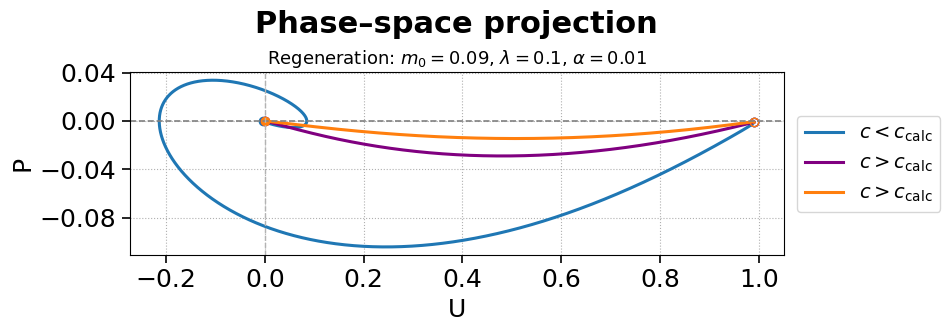

In [37]:
lam   = 0.1
alpha = 0.01
c_meas = 0.774551534454284
mbar = alpha/(alpha + lam)
eps_up = 0.01

plot_phaseplane_recovery_appendix(
    lam=lam, alpha=alpha, m0=mbar,
    U0=0.99, P0=-0.001, M0=min(1.0-1e-9, mbar + eps_up),
    speeds=[0.2*c_meas, c_meas, 2.0*c_meas],
    z_end=400.0, dz=0.01
)

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from scipy.integrate import solve_ivp

# ====== system & helpers (y = [U,P,M]) ======
def rhs_design(z, X, c, lam, alpha):
    U, P, M = X
    D = M * (1.0 - M)
    return [P,
            -c * P - U * (1.0 - U) * D,
            (D / c) * (lam * U * M - alpha * (1.0 - M))]

def make_stop_event_generic(blowU=5.0, blowP=5.0):
    def event(t, X, *args):
        U, P, M = X
        badM   = (M < -1e-6) or (M > 1.0 + 1e-6)
        blowUP = (not np.isfinite(U)) or (not np.isfinite(P)) or (abs(U) > blowU) or (abs(P) > blowP)
        return 0.0 if (badM or blowUP) else 1.0
    event.terminal  = True
    event.direction = 0
    return event

# ====== main plotting function ======
def plot_phaseplane_recovery_appendix(
    *, lam, alpha, m0,
    U0=0.99, P0=-0.001, M0=None,
    speeds=None, z_end=400.0, dz=0.01,
    rtol=1e-12, atol=1e-14, max_step=0.01,
    use_tex=False
):
    """
    Phase–plane projection onto (U,P) for regeneration case.
    - Natural figure size (no figsize forced).
    - LaTeX-style fonts:
        use_tex=False -> Computer Modern via mathtext (no LaTeX needed).
        use_tex=True  -> True LaTeX rendering (requires LaTeX installed).
    """
    if M0 is None:
        M0 = m0

    # --- fonts: LaTeX-style without requiring LaTeX by default ---
    if use_tex:
        plt.rcParams.update({
            "text.usetex": True,
            "font.family": "serif",
            "font.size": 16,
            "axes.titlesize": 22,
            "axes.labelsize": 18,
            "xtick.labelsize": 18,
            "ytick.labelsize": 18,
            "legend.fontsize": 14,
        })
    else:
        plt.rcParams.update({
            "text.usetex": False,
            "font.family": "serif",
            "font.serif": ["Computer Modern Roman", "CMU Serif", "DejaVu Serif"],
            "mathtext.fontset": "cm",
            "mathtext.rm": "serif",
            "font.size": 16,
            "axes.titlesize": 22,
            "axes.labelsize": 18,
            "xtick.labelsize": 18,
            "ytick.labelsize": 18,
            "legend.fontsize": 14,
        })

    # reference speed (for relative labels)
    cmin = 2.0*np.sqrt(m0*(1.0 - m0))

    t_eval = np.arange(0.0, z_end + dz, dz)
    guard_evt = make_stop_event_generic()

    sols = []
    for c in speeds:
        sol = solve_ivp(
            rhs_design, (0.0, z_end), [U0, P0, M0],
            args=(c, lam, alpha),
            method="BDF", rtol=rtol, atol=atol, max_step=max_step,
            t_eval=t_eval, events=guard_evt
        )
        sols.append((c, sol))

    def rel_lab(c, cref, eps=1e-12):
        if c < cref - eps:      return r"$c<c_{\rm calc}$"
        if abs(c - cref) <= eps:return r"$c=c_{\rm calc}$"
        return r"$c>c_{\rm calc}$"

    # --- natural-size figure ---
    fig, ax = plt.subplots()

    for (c, sol) in sols:
        U, P = sol.y[0], sol.y[1]
        ax.plot(U, P, lw=2.0, label=rel_lab(c, cmin))
        # start/end markers
        ax.plot(U[0],  P[0],  marker='o', ms=5, mfc='none')
        ax.plot(U[-1], P[-1], marker='o', ms=5)

    # Axes styling
    ax.axhline(0, ls='--', lw=1.0, color='0.5')
    ax.axvline(0, ls='--', lw=1.0, color='0.7')
    ax.grid(True, ls=':', alpha=0.7)
    ax.set_xlabel(r"$U$")
    ax.set_ylabel(r"$P$")
    ax.tick_params(axis='both', which='both', length=6, width=1.0)
    ax.yaxis.set_major_locator(MaxNLocator(nbins=4))

    # Title + subtitle
    ax.set_title("", fontweight='bold', pad=14)
    ax.text(
        0.5, 1.02,
        rf"$m_0={m0:.1g}$, $\lambda={lam:g}$, $\alpha={alpha:g}$",
        transform=ax.transAxes, ha="center", va="bottom", fontsize=13
    )

    # Legend outside, no frame
    ax.legend(
        frameon=False,
        loc="center left",
        bbox_to_anchor=(1.02, 0.5),
        borderaxespad=0.0
    )

    fig.tight_layout(rect=[0.0, 0.0, 0.82, 1.0])
    plt.show()

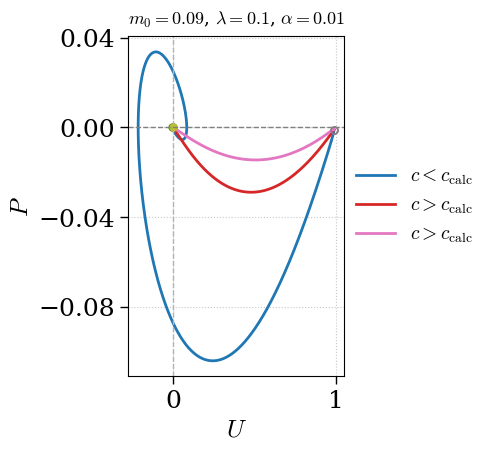

In [9]:
lam   = 0.1
alpha = 0.01
c_meas = 0.774551534454284
mbar = alpha / (alpha + lam)
eps_up = 0.01

plot_phaseplane_recovery_appendix(
    lam=lam, alpha=alpha, m0=mbar,
    U0=0.99, P0=-0.001, M0=min(1.0 - 1e-9, mbar + eps_up),
    speeds=[0.2 * c_meas, c_meas, 2.0 * c_meas],
    z_end=400.0, dz=0.01
)